In [17]:
from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import itertools
import copy
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
MinStocks = 10
MaxStocks = 22
MaxWeight = 0.2
MinWeight = 0.05
Start_date = "2023-01-01"
End_date = "2023-10-31"
TradingFee = 4.95
InvestmentAmount = 750000
ticker_file = "Tickers.csv"

In [3]:
tickers = pd.read_csv(ticker_file, header=None)##Header is none to read in the first element.
tickers.columns=["Tickers"]
exchangeCADUSD = yf.download('CADUSD=x', start=Start_date, end=End_date).tz_localize(None)
tickers

[*********************100%%**********************]  1 of 1 completed


,Tickers
0,NLNK
1,BEN
2,IRE-B
3,FORTY
4,AMG
5,RAS-A
6,CPSS
7,LXRX
8,DIS
9,MUR


In [4]:
def USDtoCAD(closing):
    #Merges the closing data with the exchange data, then removes all na values (This makes sure each closing price is matched with its dates exchange rate)
    exchanged = pd.concat([closing.to_frame(),exchangeCADUSD["Close"]],axis=1).dropna()

    #Since we are going USD to CAD, we divide by the exchange rate of that day
    converted = exchanged.iloc[:,0]/exchanged.iloc[:,1]
    return converted


In [5]:
## Consumes a series or listof possible stock symboles
def validTickers (tickers):
    ##Creates a new dataframe to hold the valid tickers closing prices
    df = pd.DataFrame()

    #Itterating through the tickers

    for i in tickers["Tickers"]:
        #Creating the ticker objects
        ticker = yf.Ticker(i)

        #Try ensures that even if an error occurs, the code will still run (this gets past the delisted stocks)
        try:
            #Running .fast_info['currency'] on a stock will cause an error and stop any non-listed stocks from being ran
            ticker.fast_info['currency']

            #Download the Daily stock history for the given time periods
            history = ticker.history(start=Start_date, end=End_date).tz_localize(None)

            #Creates a seperate dataframe with the values collected by month
            histByMonth = history['Volume'].to_frame().groupby([(history.index.month)])

            #Drops any months with less than 18 trading days
            histByMonth = histByMonth.filter(lambda x: len(x) > 17)

            #Checks for an average monthly volume greater than 150,000
            if histByMonth.sum().mean() > 150000:
                #Checking if the stock is listed in CAD or USD
                if ticker.fast_info['currency'] == 'CAD':

                    #Adding the stock to the valid tickers dataframe
                    df[i] = history['Close']

                elif ticker.fast_info['currency'] == 'USD':

                    #Adding the stocks closing data to the valid tickers dataframe after converting the prices to CAD
                    df[i] = USDtoCAD(history['Close'])
        except:
            #skips and tickers which cause an error
            pass
    return df

In [6]:
stocks_close = validTickers(tickers)
stocks_close

MZF: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
NJ: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
EVEP: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
MSK: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
ZINC: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
CCIH: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
SWHC: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
USU: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)
IFON: No price data found, symbol may be delisted (1d 2023-01-01 -> 2023-10-31)


,BEN,AMG,CPSS,LXRX,DIS,MUR,PFMT,TER,MAA,CRAI,...,GNK,RAIL,PFBX,GGG,IMCB,MAS,GRMN,PBF,XRX,GES
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-03,35.133600,217.628458,11.647182,2.698241,120.242553,53.542039,4.921917,115.869064,200.701286,164.530972,...,19.284568,4.284644,18.850083,90.647307,78.042802,62.962318,123.468578,49.923408,19.195862,27.226590
2023-01-04,36.359441,222.783828,11.800748,2.803190,125.365791,54.102944,4.909002,118.878825,205.426343,167.019089,...,19.177257,4.416734,18.354576,92.143829,79.955637,65.250921,127.138212,49.797614,19.859137,28.403632
2023-01-05,35.212678,217.318550,11.098237,2.804901,123.552362,53.774850,4.800695,116.833403,196.512223,162.252238,...,19.103098,4.396143,18.100884,88.732579,77.763286,63.569938,125.092234,50.603092,19.913589,28.138834
2023-01-06,36.768350,223.471633,11.620834,2.901819,126.940871,54.653433,4.881564,123.037289,204.446867,165.169927,...,19.797747,4.352728,19.826402,91.574548,80.007830,65.940887,129.494225,52.159869,20.876408,28.860298
2023-01-09,36.597096,226.963394,11.151217,2.834827,126.911773,54.751922,4.782931,124.537929,199.303848,156.541478,...,19.615683,4.299264,19.644073,91.407037,79.615520,66.255413,128.434129,49.638792,20.457535,28.225683
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-24,30.559899,168.700960,11.991127,1.628932,112.645135,61.959748,2.943028,125.103162,175.679650,132.299358,...,18.963581,3.695895,15.643007,96.527833,78.607324,66.925505,139.282172,64.014694,16.965820,29.320084
2023-10-25,30.270490,166.992158,12.175057,1.566542,110.383804,61.968005,2.885736,120.516116,173.099712,132.484199,...,18.669998,3.710232,15.703689,95.628148,77.626680,66.077679,139.002726,63.169876,16.407863,29.189785
2023-10-26,31.074829,169.862452,12.422611,1.587334,109.761820,62.175875,3.050441,117.211850,166.268930,133.281353,...,18.357184,3.643966,15.773742,102.839119,77.959230,70.767062,138.415139,63.986958,16.671746,29.319999


In [7]:
def USDtoCAD(closing):
    #Merges the closing data with the exchange data, then removes all na values (This makes sure each closing price is matched with its dates exchange rate)
    exchanged = pd.concat([closing.to_frame(),exchangeCADUSD["Close"]],axis=1).dropna()

    #Since we are going USD to CAD, we divide by the exchange rate of that day
    converted = exchanged.iloc[:,0]/exchanged.iloc[:,1]
    return converted


In [8]:
corr = stocks_close.corr()##Gets correlation between each stock pair
valid_tickers = list(stocks_close.columns.values)
corr

,BEN,AMG,CPSS,LXRX,DIS,MUR,PFMT,TER,MAA,CRAI,...,GNK,RAIL,PFBX,GGG,IMCB,MAS,GRMN,PBF,XRX,GES
BEN,1.000000,0.794284,0.298921,0.181956,0.590267,-0.001984,0.629643,0.446637,0.782365,0.725713,...,0.607827,0.712542,0.555452,-0.291768,0.662471,0.176022,-0.553411,-0.105836,0.601606,0.214774
AMG,0.794284,1.000000,0.332725,0.454540,0.689990,-0.276032,0.713936,0.163628,0.857857,0.630920,...,0.568423,0.708044,0.588628,-0.284916,0.305889,-0.173470,-0.637885,-0.438579,0.370554,0.032408
CPSS,0.298921,0.332725,1.000000,0.484188,0.131001,-0.460645,0.161322,0.546496,0.428624,-0.238021,...,-0.049788,0.095651,-0.174756,0.513246,0.337024,0.315868,0.000838,-0.365572,-0.105950,-0.402494
LXRX,0.181956,0.454540,0.484188,1.000000,0.589737,-0.845250,0.462021,0.060554,0.640209,-0.031878,...,0.150204,0.319780,0.051519,0.028813,-0.191952,-0.311065,-0.464068,-0.813532,-0.279831,-0.620730
DIS,0.590267,0.689990,0.131001,0.589737,1.000000,-0.450339,0.763893,-0.023515,0.785726,0.560636,...,0.756454,0.782312,0.469829,-0.570208,-0.036488,-0.492184,-0.801158,-0.541323,0.100480,-0.191578
MUR,-0.001984,-0.276032,-0.460645,-0.845250,-0.450339,1.000000,-0.424921,-0.051115,-0.419502,0.161703,...,-0.054315,-0.194072,0.050270,-0.073421,0.408196,0.379746,0.436472,0.825759,0.447804,0.796598
PFMT,0.629643,0.713936,0.161322,0.462021,0.763893,-0.424921,1.000000,0.074728,0.694051,0.614202,...,0.644323,0.671653,0.450441,-0.468244,0.014779,-0.417758,-0.822083,-0.499477,0.142233,-0.142132
TER,0.446637,0.163628,0.546496,0.060554,-0.023515,-0.051115,0.074728,1.000000,0.287188,0.051950,...,0.046765,0.098922,-0.128688,0.336276,0.632998,0.475617,0.081515,0.095355,0.292045,0.001266
MAA,0.782365,0.857857,0.428624,0.640209,0.785726,-0.419502,0.694051,0.287188,1.000000,0.559254,...,0.578600,0.725659,0.456914,-0.199199,0.363046,-0.068687,-0.649447,-0.552921,0.283276,-0.110936
CRAI,0.725713,0.630920,-0.238021,-0.031878,0.560636,0.161703,0.614202,0.051950,0.559254,1.000000,...,0.765279,0.779528,0.776322,-0.672535,0.287900,-0.184393,-0.650578,0.086037,0.588287,0.416770


['AMG', 'MAA', 'ALVR', 'DIS', 'NAD', 'PFMT', 'RAIL', 'BEN', 'AMRC', 'NICE'] 0.7011047018823757


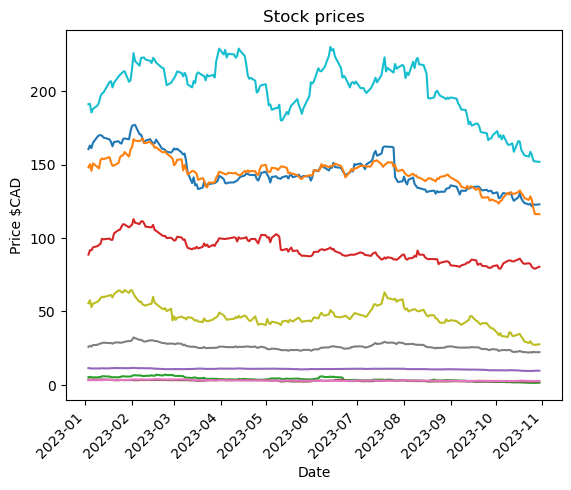

In [22]:
#Takes a list of tickers and returns the average correlation among them
def avg_corr(tickers):
    #amount of tickers
    amount = len(tickers)
    #In the case where you only give one ticker, we define
    #The correlation to 1, even though there is nothing to
    #correlated to. This is just here for failsafe as
    #the code would run into a divide by 0 error later for
    #the case where amount = 1.
    if amount == 0:
        return 1;
    sum = 0
    for i in tickers:
        for j in tickers:
            if not i==j:
              sum+=corr[i][j]
    #The average is the sum of each correlation pair divided by the
    #total amount of pairs compared which can be represented as n*(n-1)
    #Yes you can technically reduce the amount of comparisons by 50%
    #but this won't be a problem unless there are like 10000+ stocks.
    average = sum/(amount*(amount-1))
    return average


max_corr = -1
selected = []

#Given an amount to brute force, a list of stocks and a ticker,
#it returns a list of tickers of length n+1, where it includes
#n+1 stocks with the highest average correlation between them,
#given that the ticker given is 1 of the stocks in the list.
#n=amount of tickers to brute force
#selections= list of all tickers you can choose from
#stock= ticker that has to be included in the returned list
def brute_force_Nstocks(n, selections, stock):
    #Get all combos of the selections.
    combos = (list(itertools.combinations(valid_tickers,n)))
    max_corr = -1
    selected = []
    #We check each list in combo to see which has the highest
    #average correlation once you add the given ticker
    for i in combos:
        #We don't want to include the given ticker twice
        if not stock in i:
            temp = list(i)
            temp.append(stock)
            corr = avg_corr(temp)
            #If this list's average correlation is larger
            #than the current max, update the max correlation.
            if corr>max_corr:
                max_corr = corr
                selected = temp
    return selected

#Given how many stocks to brute force for highest average
#correlation and given how many total stocks you want
#in your portfolio, and the list of all options of tickers
#you can choose from, give a rough estimate for
#a portfolio with total amount of stocks with the highest
#average correlation between them.
#We are estimating the best portfolio because
def estimate_best_corr(bf, total, selections):
    #We subtract 1 from the amount we brute force, because
    #we will run the brute_force_Nstocks function on each ticker
    #which creates a list of stocks of length n+1, so
    #substituting bf-1 into n will give us
    #a list of length (bf-1)+1 = bf which is ultimately
    #how many stocks we want
    bf = bf-1
    max_corr = -1
    estimated_selected = []
    #We will run the brute force function on each stock.
    for i in selections:
        #Brute_force_Nstocks on said stock
        selected = brute_force_Nstocks(bf, selections, i)
        best_selected = selected
        #For the remaining stocks we need to add to the portfolio
        #we just repeatedly add the stock that creates the highest
        #possible average correlation when added to the list
        #of stocks we got from brute_force_Nstocks
        for j in range(total-bf-1):
            temp_max_corr = -1
            #Try adding each stock into the portfolio and see which
            #one gives us the highest average correlation.
            for k in selections:
                #We don't want to add the stock if it
                #is already in our portfolio
                if not k in selected:
                    #Create a temp portfolio with the stock added
                    temp_selected = copy.copy(selected)
                    temp_selected.append(k)
                    corr = avg_corr(temp_selected)
                    #If the average correlation is the highest
                    #we've seen, we update the max correlation
                    #and our best new portfolio
                    if corr>temp_max_corr:
                        temp_max_corr = corr
                        best_selected = copy.copy(temp_selected)
            #Update portfolio
            selected = copy.copy(best_selected)
        corr = avg_corr(selected)
        if corr>max_corr:
            max_corr=corr
            estimated_selected = selected
    return estimated_selected

portfolio = estimate_best_corr(3, 10, valid_tickers)
print(portfolio, avg_corr(portfolio))


for i in portfolio:
    ticker = yf.Ticker(i)
    hist = ticker.history(start=Start_date, end=End_date)
    plt.plot(hist.index, hist['Close']);
    plt.title("Stock prices");
    plt.ylabel("Price $CAD")
    plt.xlabel("Date")
    plt.xticks(rotation=45, ha='right')

In [10]:
#Returns average weekly return of a stock
def weekly_return(ticker):
    close = stocks_close[ticker]
    returns=close.resample('W').ffill().pct_change()
    return returns.mean()

#Orders the portfolio in terms of which one we want to give more weight,
#and the larger the magnitude of the weekly return is, the higher
#it is prioritized.
def rankings(portfolio):
    #First puts all the tickers and their weekly returns
    #into a dictionary
    rank = {}
    for i in portfolio:
        rank[i] = weekly_return(i)
    #Sort the dictionary
    keys = list(rank.keys())
    values = list(rank.values())
    sorted_index = np.argsort(values)
    ordered = {keys[i]: values[i] for i in sorted_index}

    #Since it is in ascending order at this moment
    #in the case where the returns are negative,
    #we leave the array as it is, as the stock
    #with the lowest return (or highest magnitude)
    #is already ranked first. But if the returns are positive
    #the dict would be fliped, so if the first returns is positive,
    #we flip the dictionary
    first_val = next(iter(ordered.values()))
    if first_val>0:
      ordered = dict(reversed(list(ordered.items())))
    df = pd.DataFrame(ordered.items())
    return df


ranks = rankings(portfolio)

ranks.columns = ["Ticker","Average Weekly Returns(%)"]
ranks

,Ticker,Average Weekly Returns(%)
0,ALVR,-0.020573
1,AMRC,-0.013175
2,PFMT,-0.006720
3,AMG,-0.005555
4,MAA,-0.005090
5,NICE,-0.003479
6,BEN,-0.003393
7,RAIL,-0.003038
8,NAD,-0.002796
9,DIS,-0.002540


In [11]:
ranked = ranks["Ticker"].squeeze()
tickerObjects = []
##Converting strings to Tickers
for i in ranked:
  ticker = yf.Ticker(i)
  tickerObjects = tickerObjects+ [ticker]


In [12]:
#Putting the highest possible weight into as few stocks as possible
#returns a list of 10 numbers that represent how much we put into each stock
def BestWeights(numStocks,MaxWeight,MinWeight,InvestmentAmount):
    RemainingAmount = InvestmentAmount - TradingFee*numStocks #subtracting the trading fee each time
    RemainingStocks = numStocks
    MaxAmount = InvestmentAmount*MaxWeight
    MinAmount = InvestmentAmount*MinWeight
    Amounts = []
    #allocates the maximum weight (MaxAmount) to as few stocks as possible
    #until the remaining amount allows it and there are more than one stock remaining
    while RemainingAmount > MinAmount*(RemainingStocks+1) and RemainingStocks > 1:
        RemainingStocks = RemainingStocks - 1
        RemainingAmount = RemainingAmount - MaxAmount
        Amounts = Amounts + [MaxAmount]
    #when the above loop ends (due to insufficient remaining amount or only one stock remaining)
    #we assign the minimum weight (MinAmount) to the remaining stocks
    while RemainingStocks > 1:
        RemainingStocks = RemainingStocks - 1
        RemainingAmount = RemainingAmount - MinAmount
        Amounts = Amounts + [MinAmount]

    Amounts = Amounts + [RemainingAmount]
    sortedAmounts = sorted(Amounts, reverse=True) #sorting the list
    return sortedAmounts


WeightedAmounts = BestWeights(10,MaxWeight,MinWeight,InvestmentAmount)
WeightedAmounts

[150000.0,
 150000.0,
 150000.0,
 74950.5,
 37500.0,
 37500.0,
 37500.0,
 37500.0,
 37500.0,
 37500.0]

In [13]:
#
Portfolio_Final = pd.DataFrame()
Portfolio_Final["Ticker"] = pd.concat([Portfolio_Final,ranks.iloc[:,0]],)

counter = 0
Portfolio_Final["Currency"] = Portfolio_Final["Ticker"]
for i in tickerObjects:
  Portfolio_Final["Currency"][counter] = i.fast_info['currency']
  counter = counter + 1

counter = 0
Portfolio_Final["Shares"] = Portfolio_Final["Ticker"]
exchange = yf.Ticker("CADUSD=x")
for i in tickerObjects:
  if i.fast_info['currency'] == 'USD':
    Portfolio_Final["Shares"][counter] = (WeightedAmounts[counter]*exchange.fast_info["lastPrice"])/i.fast_info['lastPrice']
  else:
    Portfolio_Final["Shares"][counter] = WeightedAmounts[counter]/i.fast_info['lastPrice']
  counter = counter + 1

counter = 0
Portfolio_Final["Value"] = Portfolio_Final["Ticker"]
for i in tickerObjects:
  Portfolio_Final["Value"][counter] = WeightedAmounts[counter]
  counter = counter + 1

counter = 0
Portfolio_Final["Weight"] = Portfolio_Final["Ticker"]
for i in tickerObjects:
  Portfolio_Final["Weight"][counter] = round((WeightedAmounts[counter]/(InvestmentAmount-(10*TradingFee))*100),2)
  counter = counter + 1

    
#Reindexing
Portfolio_Final.index = [x for x in range(1,11)]


Portfolio_Final

,Ticker,Currency,Shares,Value,Weight
1,ALVR,USD,158276.428636,150000.0,20.0
2,AMRC,USD,4819.20397,150000.0,20.0
3,PFMT,USD,38738.986791,150000.0,20.0
4,AMG,USD,353.242642,74950.5,9.99
5,MAA,USD,214.433498,37500.0,5.0
6,NICE,USD,123.323125,37500.0,5.0
7,BEN,USD,1015.70862,37500.0,5.0
8,RAIL,USD,9202.117816,37500.0,5.0
9,NAD,USD,2449.016226,37500.0,5.0
10,DIS,USD,248.193324,37500.0,5.0


In [14]:
data = {"Ticker":Portfolio_Final["Ticker"],"Shares":Portfolio_Final["Shares"]}
Stocks_Finals = pd.DataFrame(data)


Stocks_Finals

,Ticker,Shares
1,ALVR,158276.428636
2,AMRC,4819.20397
3,PFMT,38738.986791
4,AMG,353.242642
5,MAA,214.433498
6,NICE,123.323125
7,BEN,1015.70862
8,RAIL,9202.117816
9,NAD,2449.016226
10,DIS,248.193324


In [15]:
##Exporting the csv file
myfile = open("Stocks_Group_8.csv", "w")
myfile.write(",Ticker,Shares\n")
for i in range(1, 11):
    myfile.write(str(i)+","+Stocks_Finals["Ticker"][i]+","+str(Stocks_Finals["Shares"][i])+ "\n")

myfile.close()

To output the csv, keep in mind the first column is the index, so read it in like: pd.read_csv("Stocks_Group_8.csv",index_col=0)